# Variational Autoencoders

Learning Outcomes:
- Generete new, unseen data by sampling from the latent space.
- Illustrate interpolation between different images thanks to latent representations.
- Visualize the effect of different weights on the regularization term on the learnt latent space.

## Library Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/joseba.dalmau/High-Dimensional-Deep-Learning/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


## The MNIST dataset

In [54]:
from torchvision import datasets, transforms
batch_size = 128

# Data loading
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


## 1. Define the VAE class

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(ConvVAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 14, 14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )

        # Fully connected layers for mean and log variance
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        
        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )
    
    def encode(self, x):
        x = self.encoder(x)  # Output: (128, 4, 4)
        x = x.view(-1, 128 * 4 * 4)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 128, 4, 4)  # Reshape to (128, 4, 4) for the decoder
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


## 2. Define the loss function

In [82]:
def loss_function(recon_x, x, mu, logvar, beta=1):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

## 3. Train the VAE

In [83]:
import torch.optim as optim

# Hyperparameters
batch_size = 128
latent_dim = 64
learning_rate = 1e-3
epochs = 30
beta = 1

# Model initialization
vae = ConvVAE(latent_dim=latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
vae.to(device)
print(vae)

# Training loop
def train(epoch):
    vae.train()
    running_loss = 0.0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch}, Training loss: {epoch_loss:.4f}')

# Run training
for epoch in range(1, epochs + 1):
    train(epoch)

ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fc_mu): Linear(in_features=2048, out_features=64, bias=True)
  (fc_logvar): Linear(in_features=2048, out_features=64, bias=True)
  (fc_decode): Linear(in_features=64, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3

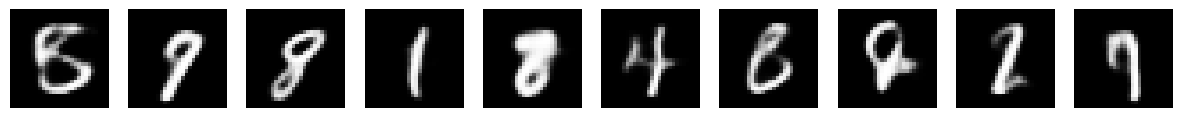

In [84]:
import matplotlib.pyplot as plt

def generate_sample(num_samples=10):
    vae.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, latent_dim).to(device)  # Sample random latent vectors
        samples = vae.decode(z).cpu()
        samples = samples.view(num_samples, 1, 28, 28)

        fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
        for i in range(num_samples):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()

generate_sample()

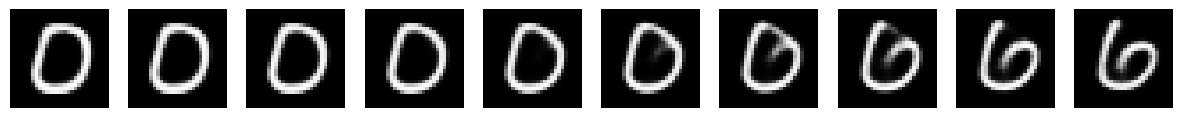

In [86]:
def interpolate(x1, x2, num_steps=10):
    vae.eval()
    with torch.no_grad():
        x1, x2 = x1.to(device), x2.to(device)
        mu1, logvar1 = vae.encode(x1.view(1, 1, 28, 28))
        mu2, logvar2 = vae.encode(x2.view(1, 1, 28, 28))

        z1 = vae.reparameterize(mu1, logvar1)
        z2 = vae.reparameterize(mu2, logvar2)

        z = torch.stack([z1 * (1 - t) + z2 * t for t in torch.linspace(0, 1, num_steps)])
        samples = vae.decode(z).cpu()
        samples = samples.view(num_steps, 1, 28, 28)

        fig, ax = plt.subplots(1, num_steps, figsize=(15, 2))
        for i in range(num_steps):
            ax[i].imshow(samples[i].squeeze(0), cmap='gray')
            ax[i].axis('off')
        plt.show()

# Example usage
x1, x2 = test_dataset[10][0], test_dataset[11][0]
interpolate(x1, x2)